# **CV-V - 2022**

The code is open source so it can be used as an starting point for your personal projects (Ref-ISBN: 9781098102333)

##### **Dataset**
The dataset can be found and freely downloaded from the below links:

- https://www.kaggle.com/competitions/tpu-getting-started/data
- https://www.kaggle.com/competitions/flower-classification-with-tpus/data

# **Always Run The Below Cell**

In [16]:
from google.colab import auth
auth.authenticate_user()
project_id = 'flowerproject-361413'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://104-flowers/


In [17]:
!gcloud beta services identity create --service tpu.googleapis.com --project $project_id

Service identity created: service-1010703852503@cloud-tpu.iam.gserviceaccount.com


In [18]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten
import matplotlib
import math, re, os, sys
import random
from google.colab import drive
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

'''drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/AABC')'''

"drive.mount('/content/drive')\nos.chdir('/content/drive/My Drive/AABC')"

In [19]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.32.236.2:8470']


REPLICAS:  8


# Configuration 

- Settings for TPUv3. When running on hardware with less memory such as a TPUv2 (Colab) or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

Learning rate schedule: 0.0002 to 0.0008 to 1.37e-05


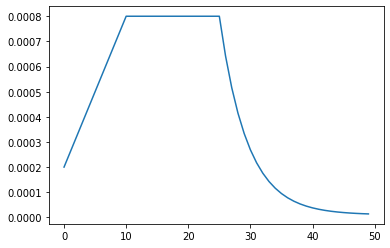

In [24]:
GCS_DS_PATH = "gs://practical-ml-vision-book/flowers_104_tfr"

# Settings for TPUv3 / T4 with sufficient memory. 
# When running on hardware with less memory such as a TPUv2 (Colab)
# or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

IMAGE_SIZE = [224, 224] # available image sizes in flowers104 dataset: 512x512, 331x331, 224x224, 192,192
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 50

# Learning rate schedule
LR_START = 0.0002
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 15
LR_EXP_DECAY = .8

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

# This dataset is split three ways, training, validation, test
# but we will use it split two ways only: training and validation.
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
VALIDATION_FILENAMES =  tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Utilities

In [26]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation,'--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) # decoded inamge in uint8 format range [0,255]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    idnum = example['id'] # image id, not used
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)



In [27]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 16465 training images, 7382 validation images


In [30]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(50)
train_batch = iter(training_dataset)
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

Output hidden; open in https://colab.research.google.com to view.

# **Transformer Model**

The Vision Transformer (ViT) model adapts the Transformer idea to work on images. The equivalent of words in images are square patches, so the first step is to take the input image and break it into patches.

https://doi.org/10.48550/arXiv.2010.11929

In [34]:
PATCH_SIZE = 16
num_patches = (IMAGE_SIZE[0] // PATCH_SIZE) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Set up patch creation as a layer
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

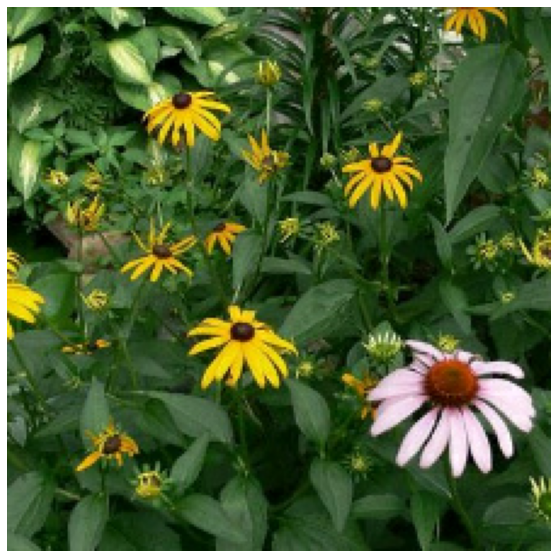

In [63]:
image = next(train_batch)[0]
plt.figure(figsize= (10,10))
plt.imshow(image[0])
plt.axis('off');

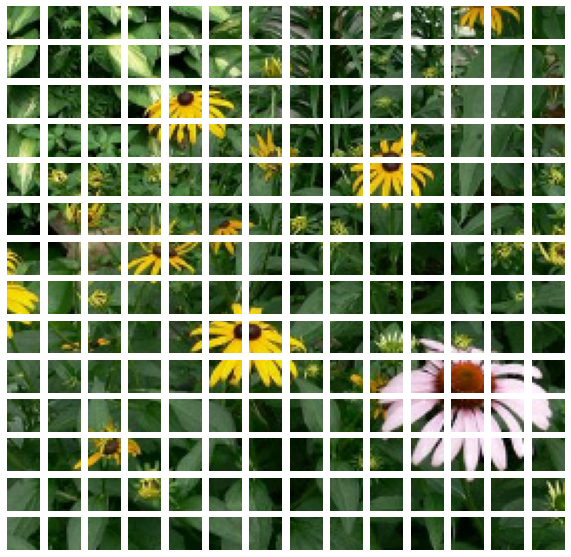

In [64]:
patches = Patches(PATCH_SIZE)(image)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize= (10,10))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [67]:
# The PatchEncoder layer projecting the patch into a vector of size projection_dim. It also adds a learnable position embedding to the projected vector.
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
        
# The ViT model has multiple Transformer blocks, which use a self-attention mechanism on the patches.
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    # Create patches.
    patches = Patches(PATCH_SIZE)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(len(CLASSES))(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [68]:
with strategy.scope():
    model = create_vit_classifier()
    
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_4 (Patches)            (None, None, 768)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 196, 64)      61760       ['patches_4[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 196, 64)     128         ['patch_encoder[0][0]']      

In [69]:
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/50
128/128 [==============================] - 69s 539ms/step - loss: 4.4475 - sparse_categorical_accuracy: 0.0676 - val_loss: 3.9035 - val_sparse_categorical_accuracy: 0.1246 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026000000000000003.
Epoch 2/50
128/128 [==============================] - 6s 43ms/step - loss: 3.9336 - sparse_categorical_accuracy: 0.0959 - val_loss: 3.6374 - val_sparse_categorical_accuracy: 0.1389 - lr: 2.6000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00032.
Epoch 3/50
128/128 [==============================] - 6s 44ms/step - loss: 3.7933 - sparse_categorical_accuracy: 0.1072 - val_loss: 3.5056 - val_sparse_categorical_accuracy: 0.1542 - lr: 3.2000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00038.
Epoch 4/50
128/128 [==============================] - 6s 44ms/step - loss: 3.6803 - sparse_categorical_accuracy: 0.1196 - val_

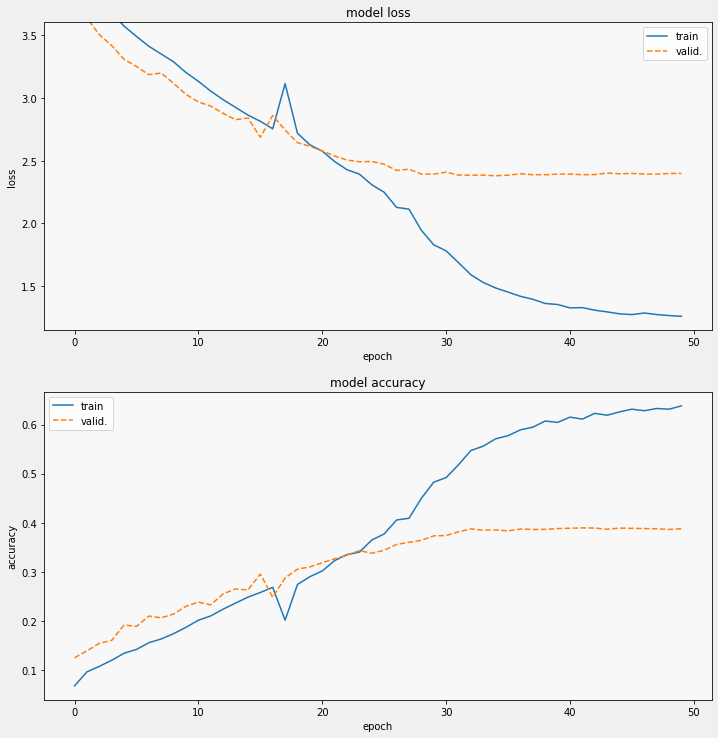

In [70]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, zoom_pcent=90)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)


In [71]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (7382,) [ 67  28  83 ...  95 102  62]
Predicted labels:  (7382,) [ 67 102  67 ...  49  47  62]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


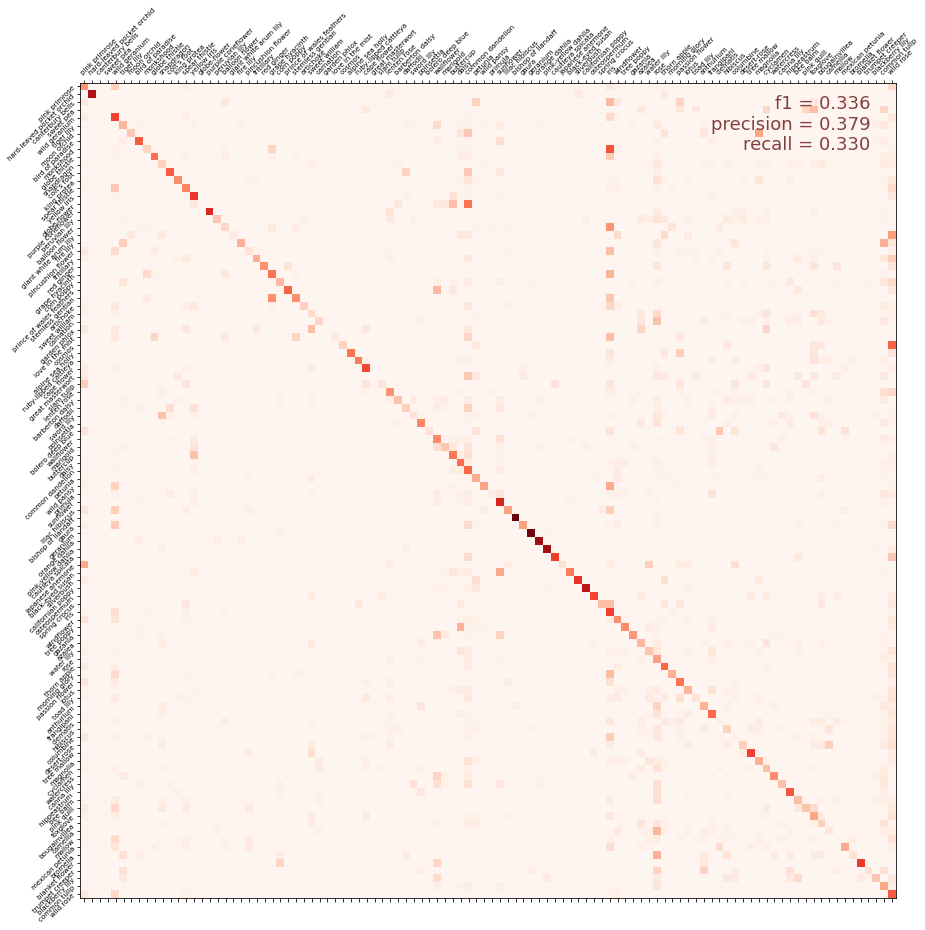

f1 score: 0.336, precision: 0.379, recall: 0.330


In [72]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

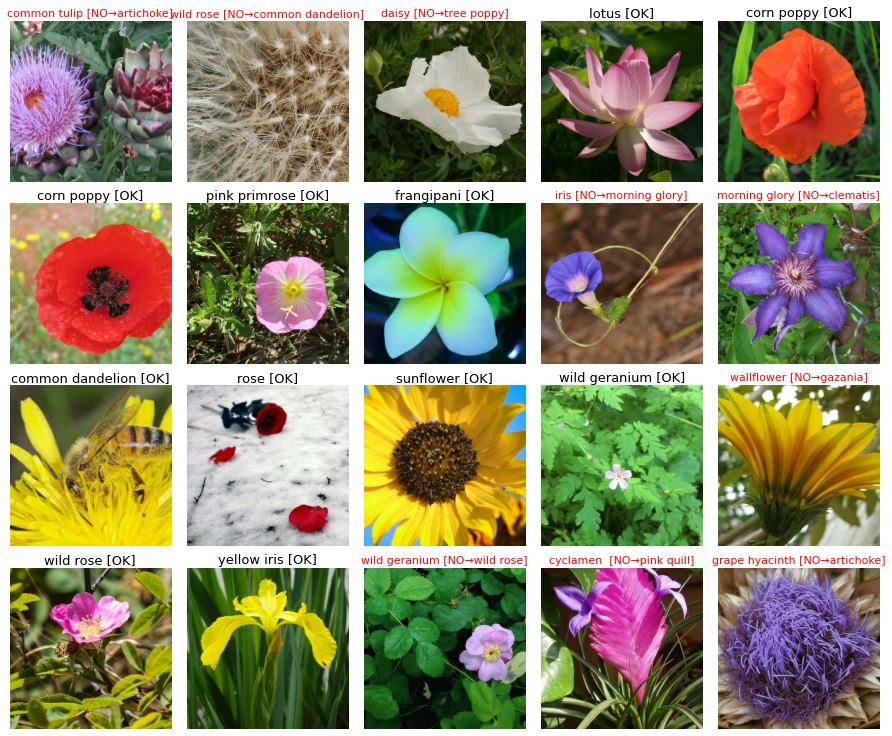

In [73]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)